# Chest X-Ray Classification


Exploring medical image diagnosis by building a state-of-the-art chest X-ray classifier using Keras.

- Pre-process and prepare a real-world X-ray dataset.
- Use transfer learning to retrain a DenseNet model for X-ray image classification.
- Learn a technique to handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve.



- Data preparation
  - Visualizing data.
  - Preventing data leakage.
- Model Development
  - Addressing class imbalance.
  - Leveraging pre-trained models using transfer learning.
- Evaluation
  - AUC and ROC curves.

<a name='1'></a>
## 1. Import Packages and Functions

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

We will also use several modules from the `keras` framework for building deep learning models.

tensorflow==2.10.0



In [1]:
!pip install tensorflow==2.10.0 # Install a specific TensorFlow version

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/My\ Drive/work/main.py /content/

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model

import main



import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


<a name='2'></a>
## 2. Load the Datasets
Using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients.
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions.
- use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies.

The dataset includes a CSV file that provides the labels for each X-ray.

<a name='2-1'></a>
### 2.1 Loading the Data
Let's open these files using the [pandas](https://pandas.pydata.org/) library

In [7]:
train_df = pd.read_csv("/content/drive/My Drive/work/train-small.csv")
valid_df = pd.read_csv("/content/drive/My Drive/work/valid-small.csv")

test_df = pd.read_csv("/content/drive/My Drive/work/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [8]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

<a name='2-2'></a>
### 2.2 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [13]:
def check_for_leakage(df1, df2, patient_col):

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    df1_patients_unique = set(df1[patient_col].unique())
    df2_patients_unique = set(df2[patient_col].unique())

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 # boolean (true if there is at least 1 patient in both groups)

    ### END CODE HERE ###

    return leakage

Run the next cell to check if there are patients in both train and test or in both valid and test.

In [14]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


<a name='2-3'></a>
### 2.3 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them.
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe.
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
    - This will facilitate model training by standardizing the input distribution.
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

There are a few things to note:
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [15]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

#### Build a separate generator for valid and test sets

Normalizing incoming test data using the statistics computed from the training set.

In [16]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.__next__()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [17]:
IMAGE_DIR = "/content/drive/My Drive/work/W1A1/data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Let's peek into what the generator gives our model during training and validation. We can do this by calling the `__get_item__(index)` function:

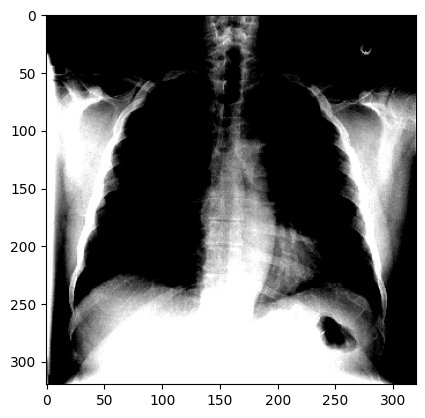

In [18]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3. Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

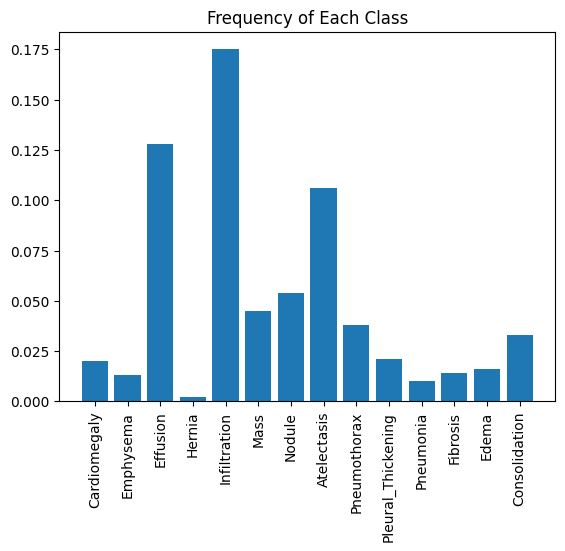

In [19]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.)
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss.

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$${L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive.

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero).

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows:

$${L}_{cross-entropy}({D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

In [20]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1-(np.sum(labels, axis=0) / N)

    return positive_frequencies, negative_frequencies

In [21]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

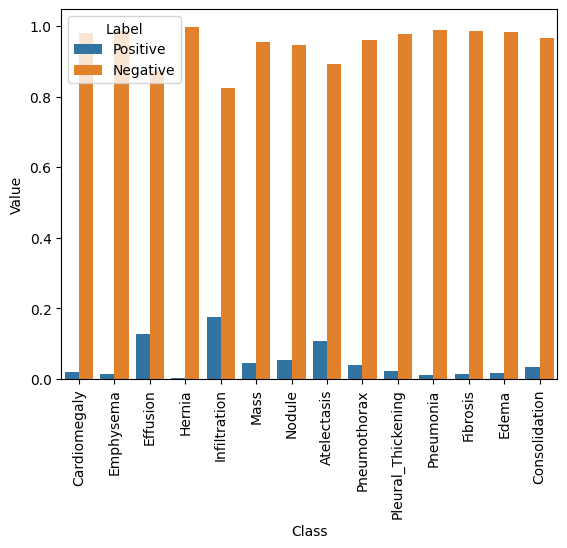

In [22]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.

To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [23]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

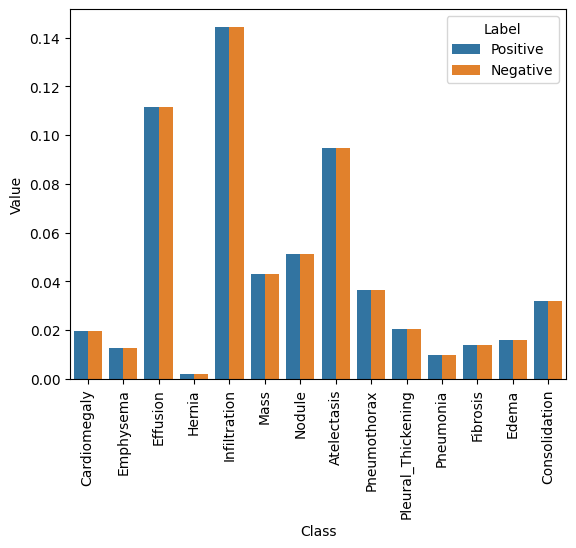

In [24]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data,pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)])], ignore_index=True)

#data = pd.concat([data,([{"Class": labels[l], "Label": "Negative", "Value": v}
#                        for l,v in enumerate(neg_contribution)])], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be

$$ {L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [29]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        y_true = tf.cast(y_true, tf.float32)
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += (-1 * tf.keras.backend.mean(pos_weights[i] * y_true[:, i] * tf.keras.backend.log(y_pred[:, i] + epsilon)))+(-1 * tf.keras.backend.mean(neg_weights[i] *(1- y_true[:, i]) * tf.keras.backend.log((1-y_pred[:, i]) + epsilon)))
        return loss

    return weighted_loss



<a name='3-2'></a>
### 3.2 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [30]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense # Import necessary layers
# create the base pre-trained model
base_model = DenseNet121(weights='/content/drive/My Drive/work//W1A1/models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## 4. Training

With our model ready for training, we will use the `model.fit()` function in Keras to train our model.
- We are training on a small subset of the dataset (~1%).  
- So what we care about at this point is to make sure that the loss on the training set is decreasing.


Epoch 1/3
100/100 [==============================] - 1357s 13s/step - loss: 0.9745 - val_loss: 8.9644
Epoch 2/3
100/100 [==============================] - 1299s 13s/step - loss: 0.8616 - val_loss: 9.7460
Epoch 3/3
100/100 [==============================] - 1283s 13s/step - loss: 0.8557 - val_loss: 1.3994


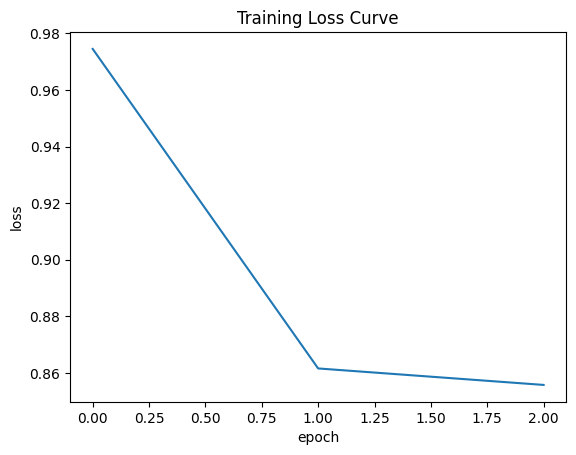

In [31]:
history = model.fit(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=100,
                              validation_steps=25,
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

<a name='4-1'></a>
### 4.1 Training on the Larger Dataset

Given that the original dataset is 40GB+ in size and the training process on the full dataset takes a few hours, we have trained the model on a GPU-equipped machine for you and provided the weights file from our model (with a batch size of 32 instead)



In [32]:
model.load_weights("/content/drive/My Drive/work//W1A1/models/nih/pretrained_model.h5")

We can check the architecture of our model using the summary() method.

After running the code block below we’ll see that this model has a lot of layers. One advantage of Grad-CAM over previous attempts of interpreting CNN's (such as CAM) is that it is architecture agnostic. This means it can be used for CNN's with complex architectures such as this one:

In [33]:
# Print all of the model's layers
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_2[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_2[0][0]']       
                                64)                                                         

Keras models include abundant information about the elements that make them up. You can check all of the available methods and attributes of this class by using the dir() method:

In [34]:
# Printing out methods and attributes for Keras model
print(f"Keras' models have the following methods and attributes: \n\n{dir(model)}")

Keras' models have the following methods and attributes: 

['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__annotations__', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_assert_compile_was_called', '_assert_weights_created', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_base_model_initialized', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer', '_cast_single_input', '_check_call_args', '_check_sample_weight_warning', '_checkpoint', '_checkpoint_dependencie

Wow, this certainly is a lot! These models are indeed very complex.

What we are interested in are the layers of the model which can be easily accessed as an attribute using the dot notation. They are a list of layers, which can be confirmed by checking its type:

In [35]:
# Check the type of the model's layers
type(model.layers)

list

In [36]:
# Print 5 first layers along with their names
for i in range(5):
    l = model.layers[i]
    print(f"Layer number {i}: \n{l} \nWith name: {l.name} \n")

Layer number 0: 
With name: input_2 

Layer number 1: 
With name: zero_padding2d_2 

Layer number 2: 
With name: conv1/conv 

Layer number 3: 
With name: conv1/bn 

Layer number 4: 
With name: conv1/relu 



Let's check how many layers our model has:

In [37]:
# Print number of layers in our model
print(f"The model has {len(model.layers)} layers")

The model has 429 layers


Our main goal is interpreting the representations which the neural net is creating for classifying our images. But as you can see this architecture has many layers.

Actually we are really interested in the representations that the convolutional layers produce because these are the layers that (hopefully) recognize concrete elements within the images. We are also interested in the "concatenate" layers because in our model's arquitecture they concatenate convolutional layers.

Let's check how many of those we have:

In [38]:
# Number of layers that are of type "Convolutional" or "Concatenate"
len([l for l in model.layers if ("conv" in str(type(l))) or ("Concatenate" in str(type(l)))])

178

Let's test the functions for computing the last layer activation which we just defined on a particular image. Don't worry about the code to load the image, this has been taken care of for you. You should only care that an image ready to be processed will be saved in the x variable:



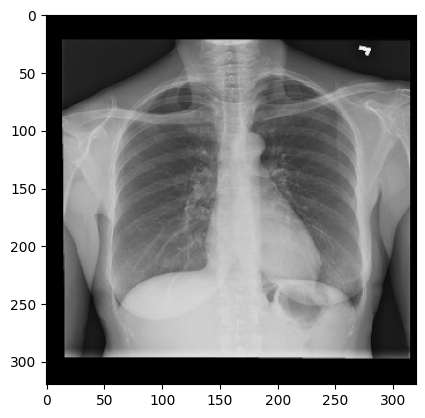

In [40]:
# Load dataframe that contains information about the dataset of images
df = pd.read_csv("/content/drive/My Drive/work/W1A1/data/nih/train-small.csv")

# Path to the actual image
IMAGE_DIR = '/content/drive/My Drive/work/W1A1/data/nih/images-small/'
im = '00000599_000.png'

# Load the image and save it to a variable
x = main.load_image(im,IMAGE_DIR , df, preprocess=False)

# Display the image
plt.imshow(x, cmap = 'gray')
plt.show()

We should normalize this image before going forward, this has also been taken care of:

In [41]:
# Load the image and save it to a variable
x = main.load_image(im,IMAGE_DIR , df, preprocess=True)

Now we have everything we need to compute the actual values of the last layer activations. In this case we should also **provide the input as a list or tuple**:

<a name='5'></a>
## 5. Prediction and Evaluation

Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.

**Note:** The following cell can take about 4 minutes to run.

In [42]:
predicted_vals = model.predict(test_generator)

53/53 [==============================] - 195s 4s/step


util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

<a name='5-1'></a>
### 5.1 ROC Curve and AUROC
Computing a metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. This is also referred to as the AUROC value, but you will see all three terms in reference to the technique, and often used almost interchangeably.

For now, what you need to know in order to interpret the plot is that a curve that is more to the left and the top has more "area" under it, and indicates that the model is performing better.

We will use the `util.get_roc_curve()` function which has been provided in `util.py`. Look through this function and note the use of the `sklearn` library functions to generate the ROC curves and AUROC values for our model.

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

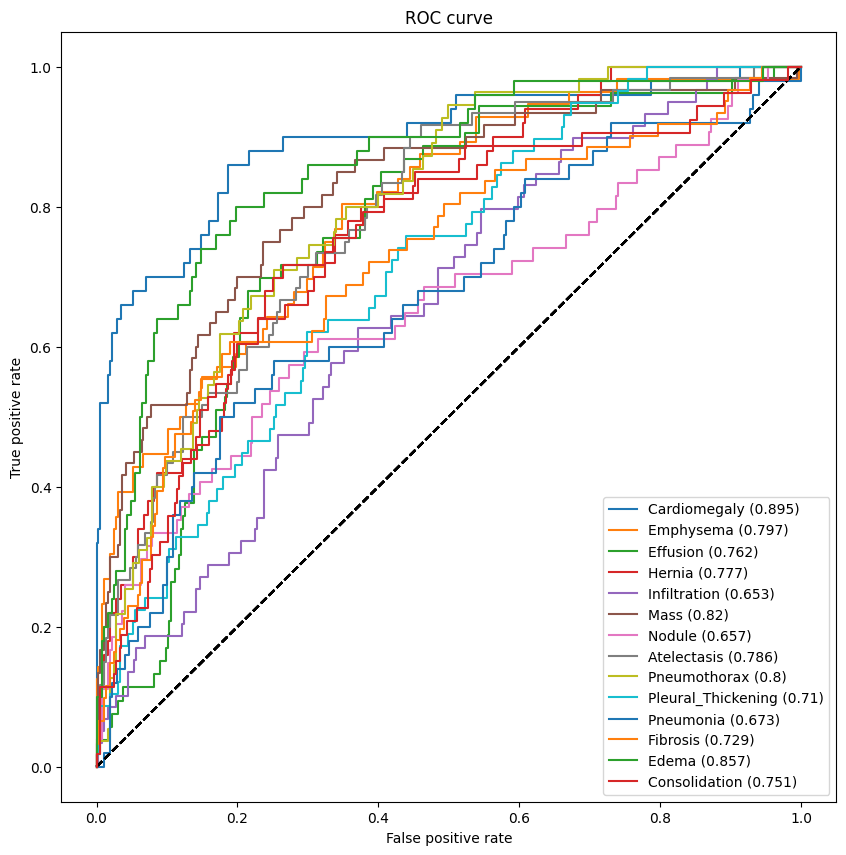

In [44]:
auc_rocs = main.get_roc_curve(labels, predicted_vals, test_generator)

You can compare the performance to the AUCs reported in the original ChexNeXt paper in the table below:

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">

This method does take advantage of a few other tricks such as self-training and ensembling as well, which can give a significant boost to the performance.